In [ ]:
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

import datetime as dt

%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score, f1_score, mean_squared_log_error

In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
test = pd.read_csv('/content/gdrive/MyDrive/Datasets/sberbank_housing/test.csv', sep=',')
train = pd.read_csv('/content/gdrive/MyDrive/Datasets/sberbank_housing/train.csv', sep=',')
macro = pd.read_csv('/content/gdrive/MyDrive/Datasets/sberbank_housing/macro.csv', sep=",")

In [5]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [6]:
train['price_doc'].dtype

dtype('int64')

Text(0, 0.5, 'price_doc')

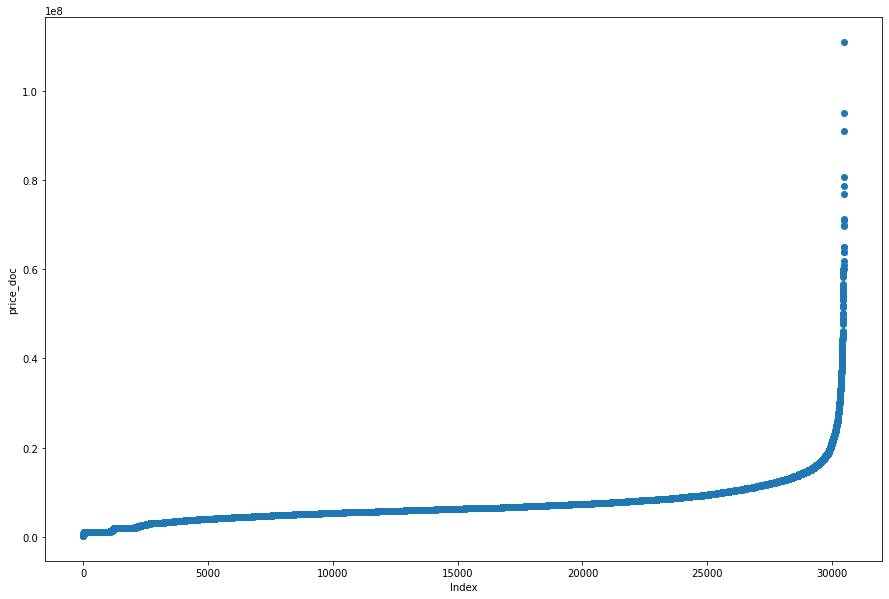

In [7]:
plt.figure(figsize=(15, 10))

plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel("Index")
plt.ylabel("price_doc")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'price')

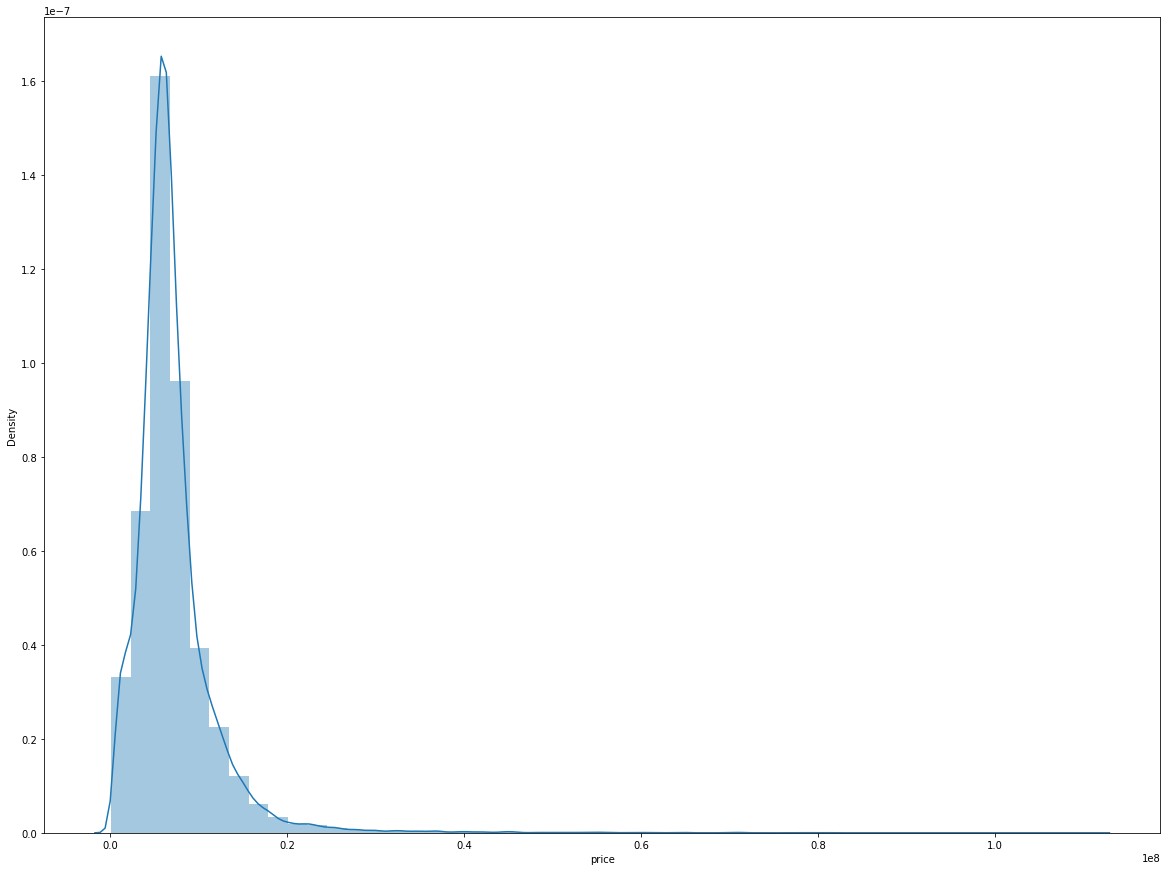

In [8]:
plt.figure(figsize=(20, 15))
sns.distplot(train['price_doc'].values, bins=50, kde=True)
plt.xlabel('price')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'price')

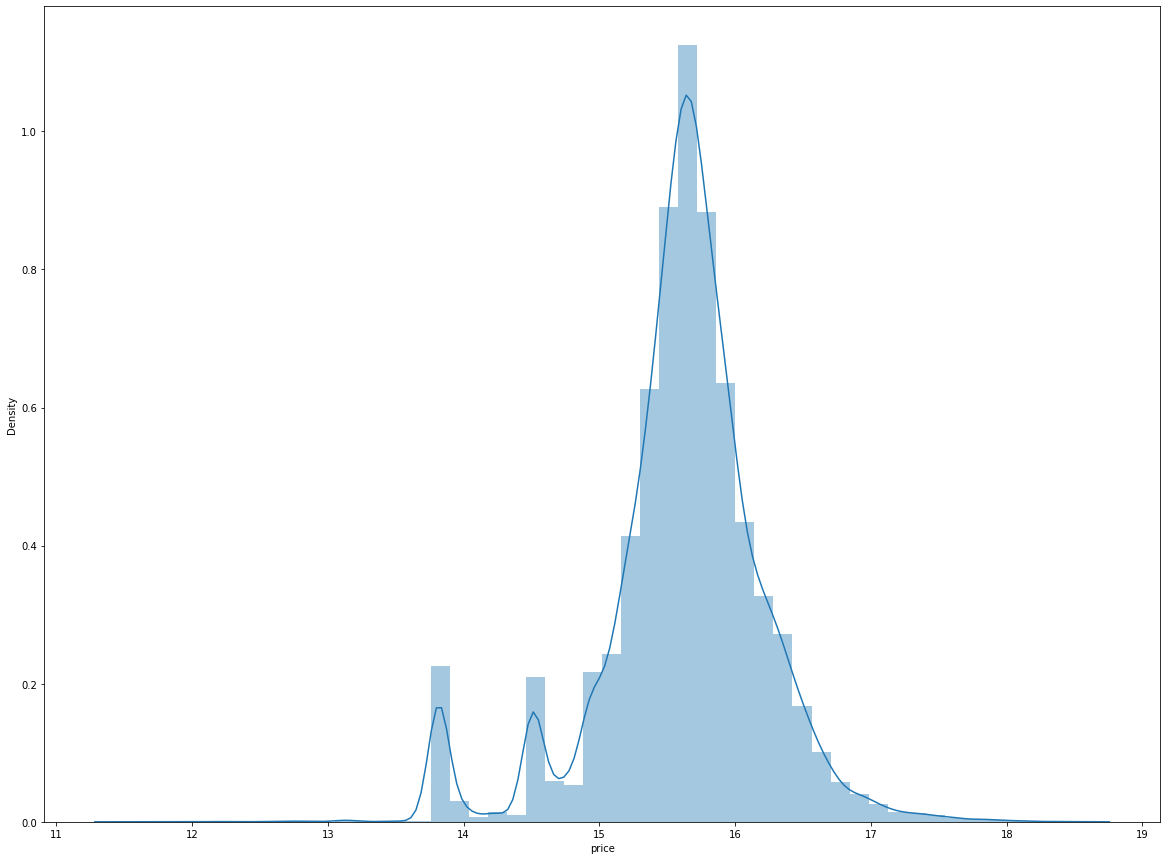

In [9]:
plt.figure(figsize=(20, 15))
sns.distplot(np.log(train['price_doc'].values), bins=50, kde=True)
plt.xlabel('price')

In [10]:
missing = train.isnull().sum(axis=0).reset_index()
missing.columns = ['name', 'missing_count']

missing = missing.loc[missing['missing_count'] > 0, :]
missing.sort_values(by='missing_count', inplace=True)

idx = range(missing.shape[0])
idx

range(0, 51)

In [11]:
train.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)

In [12]:
corr = train.corr()
corr['price_doc'].sort_values(ascending=False).reset_index()


,index,price_doc
0,price_doc,1.000000
1,num_room,0.476337
2,full_sq,0.341840
3,sport_count_5000,0.294864
4,sport_count_3000,0.290651
...,...,...
271,ttk_km,-0.272620
272,bulvar_ring_km,-0.279158
273,kremlin_km,-0.279249
274,sadovoe_km,-0.283622


Text(0.5, 0, 'Number of missing values')

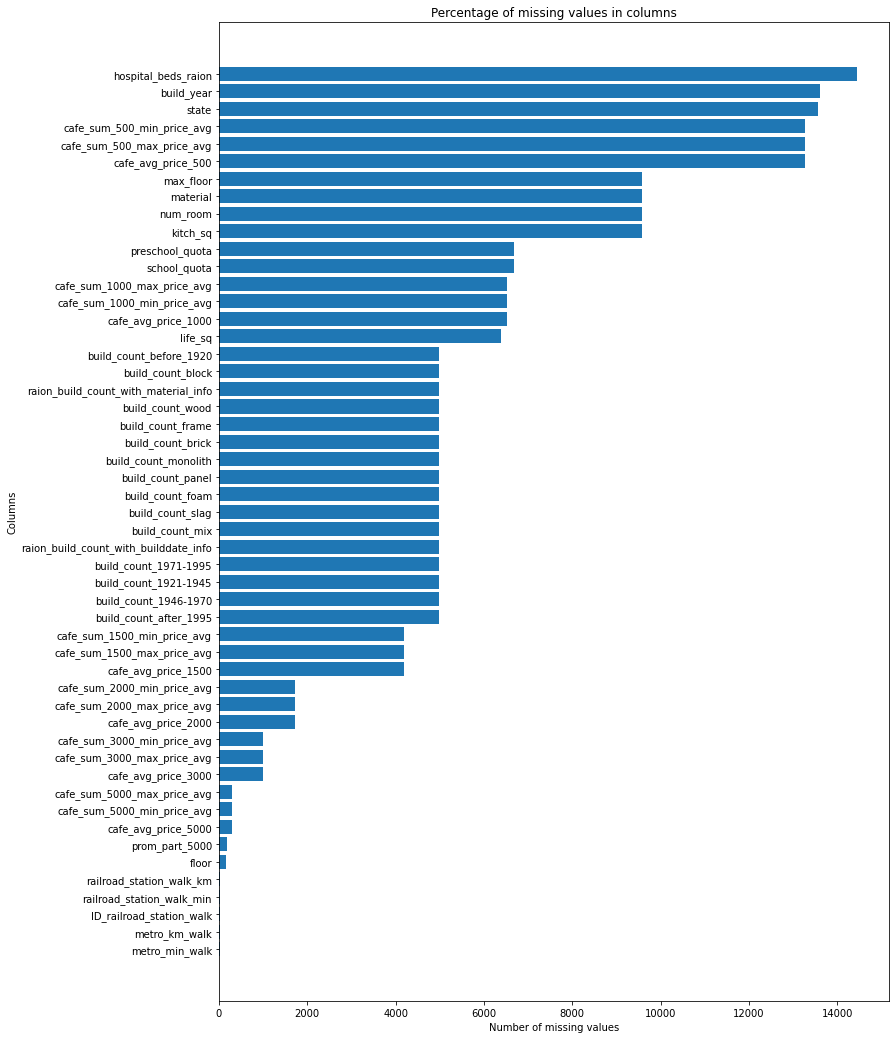

In [13]:
fig, ax = plt.subplots(figsize=(12, 18))

ax.barh(idx, missing['missing_count'])
ax.set_yticks(idx)
ax.set_yticklabels(missing['name'].values)

ax.set_title("Percentage of missing values in columns")
ax.set_ylabel("Columns")
ax.set_xlabel("Number of missing values")

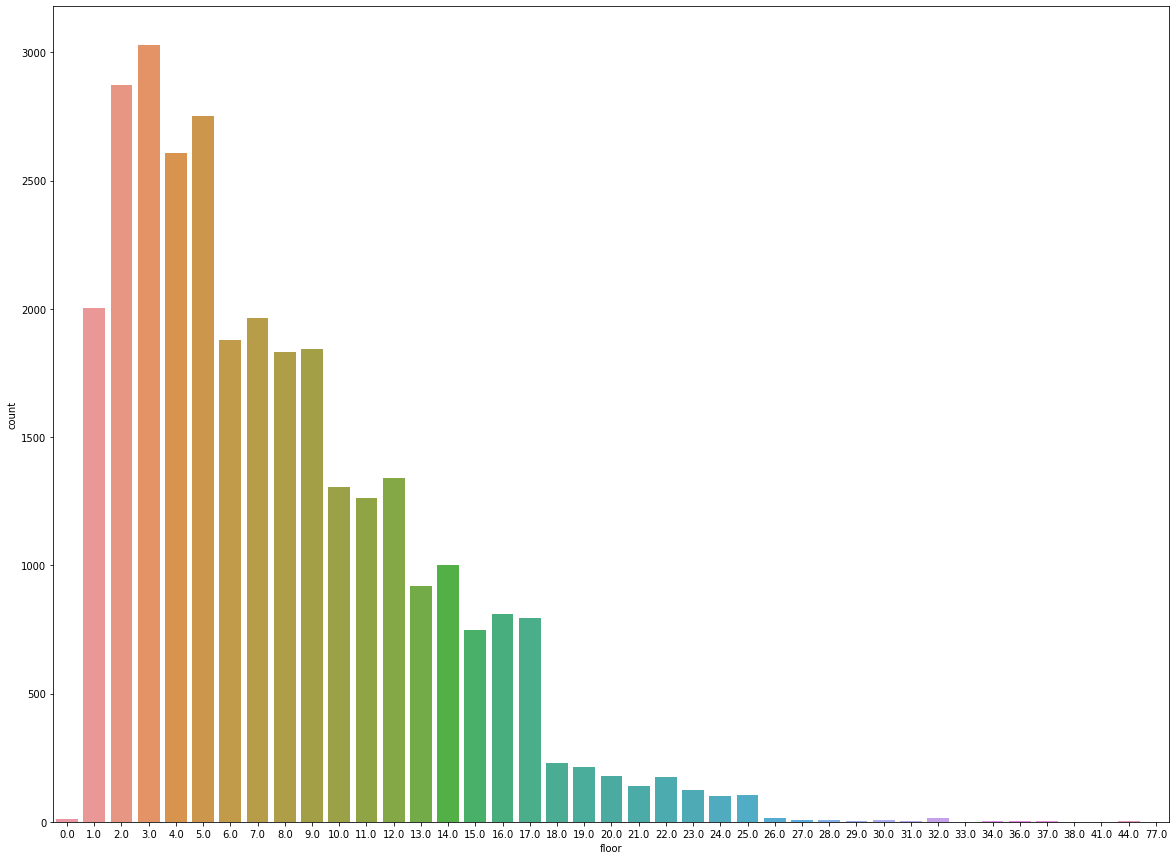

In [14]:
plt.figure(figsize=(20, 15))
sns.countplot(x='floor', data=train)

# ax.set_title("")

In [15]:
train['timestamp'] = train['timestamp'].astype(np.datetime64)
train['yearmonth'] = train['timestamp'].map(lambda x: 100*x.year + x.month)

In [16]:
test['timestamp'] = test['timestamp'].astype(np.datetime64)
test['yearmonth'] = test['timestamp'].map(lambda x: 100*x.year + x.month)

In [17]:
train_yearmonth = train.groupby('yearmonth')['price_doc'].aggregate(np.median).sort_values(ascending=False).reset_index()
train_yearmonth

,yearmonth,price_doc
0,201503,7300000.0
1,201501,7300000.0
2,201502,7259103.0
3,201506,7100000.0
4,201505,7000000.0
5,201504,6999450.0
6,201409,6900000.0
7,201412,6729040.0
8,201404,6675785.0
9,201408,6671450.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 <a list of 47 Text major ticklabel objects>)

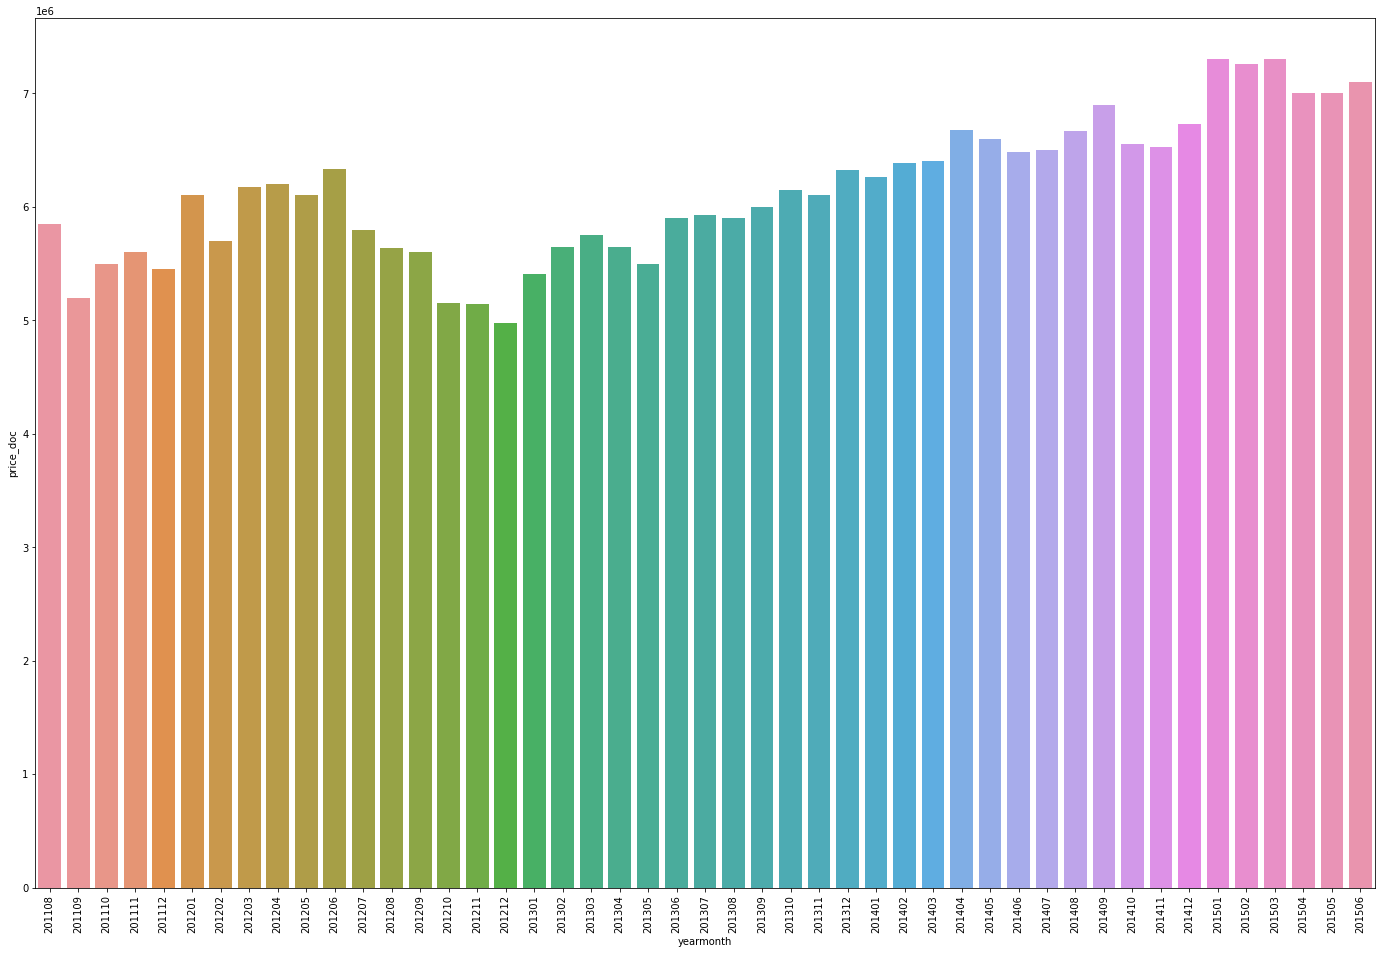

In [19]:
plt.figure(figsize=(24, 16))
sns.barplot(
    x = train_yearmonth['yearmonth'],
    y = train_yearmonth['price_doc'],
    data = train_yearmonth
)

plt.xticks(rotation='vertical')

In [21]:
general_info = [
    'id', 'timestamp',
    'full_sq', 'life_sq',
    'floor', 'max_floor',
    'material', 'build_year',
    'num_room', 'kitch_sq',
    'state', 'product_type', 'sub_area', 'price_doc']


In [22]:
general_df = train[general_info]

# dropping id column
general_df.drop('id', axis=1, inplace=True )

general_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,16331452


In [23]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     30471 non-null  datetime64[ns]
 1   full_sq       30471 non-null  int64         
 2   life_sq       24088 non-null  float64       
 3   floor         30304 non-null  float64       
 4   max_floor     20899 non-null  float64       
 5   material      20899 non-null  float64       
 6   build_year    16866 non-null  float64       
 7   num_room      20899 non-null  float64       
 8   kitch_sq      20899 non-null  float64       
 9   state         16912 non-null  float64       
 10  product_type  30471 non-null  object        
 11  sub_area      30471 non-null  object        
 12  price_doc     30471 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 3.0+ MB


In [24]:
general_df.isnull().sum()

timestamp           0
full_sq             0
life_sq          6383
floor             167
max_floor        9572
material         9572
build_year      13605
num_room         9572
kitch_sq         9572
state           13559
product_type        0
sub_area            0
price_doc           0
dtype: int64

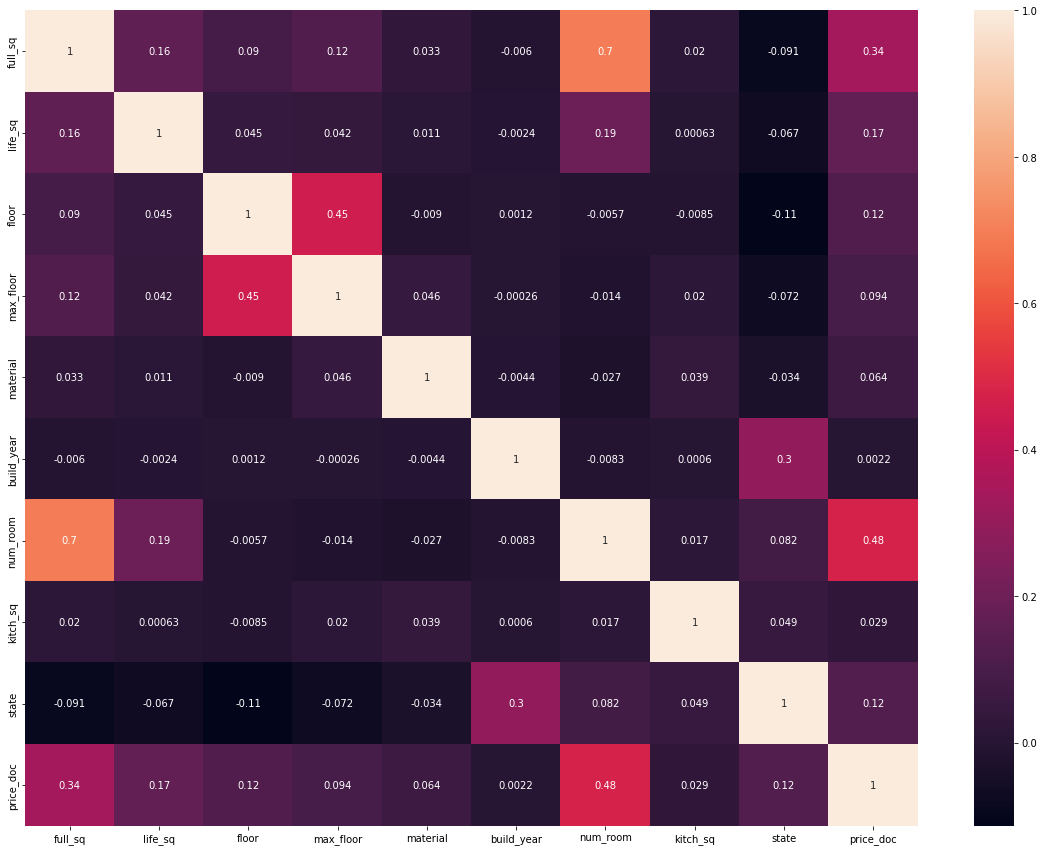

In [25]:
corr = general_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True)

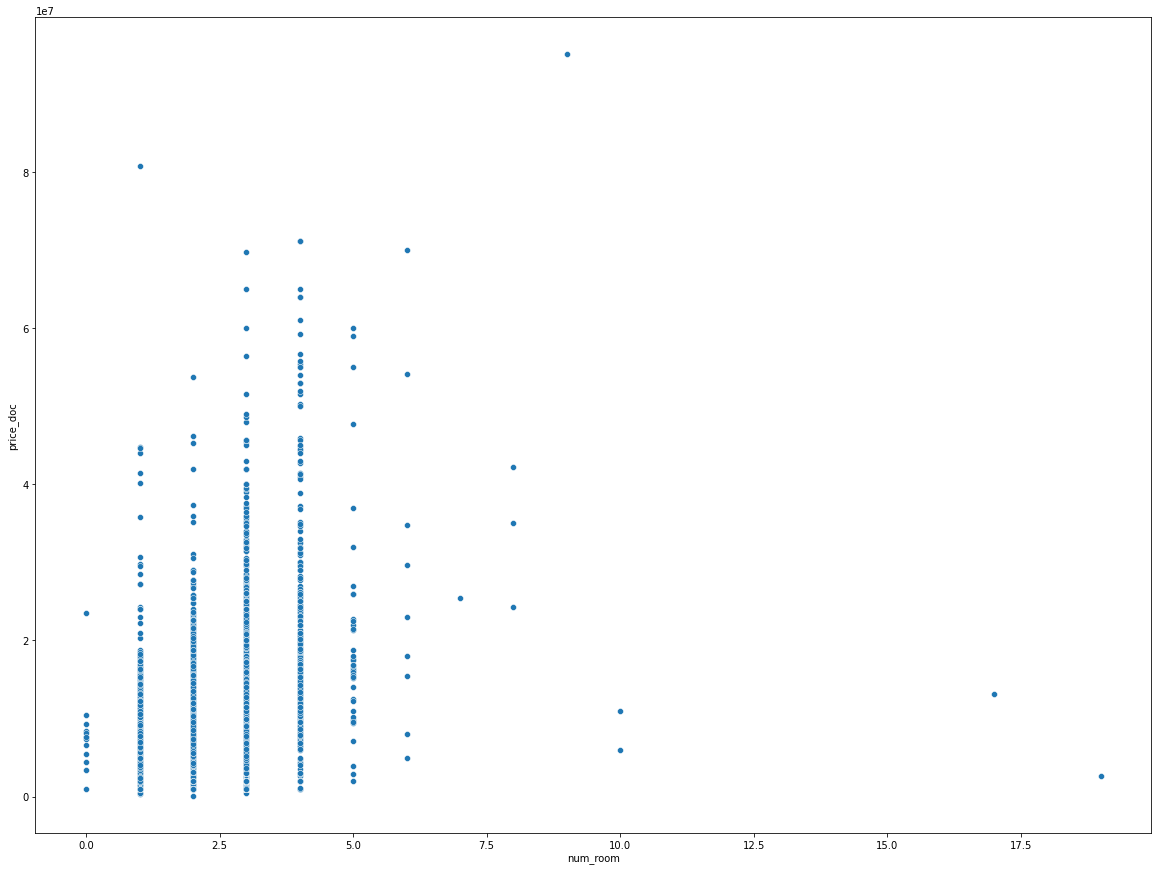

In [26]:
plt.figure(figsize=(20, 15))
sns.scatterplot(
    x = train['num_room'],
    y = train['price_doc']
)

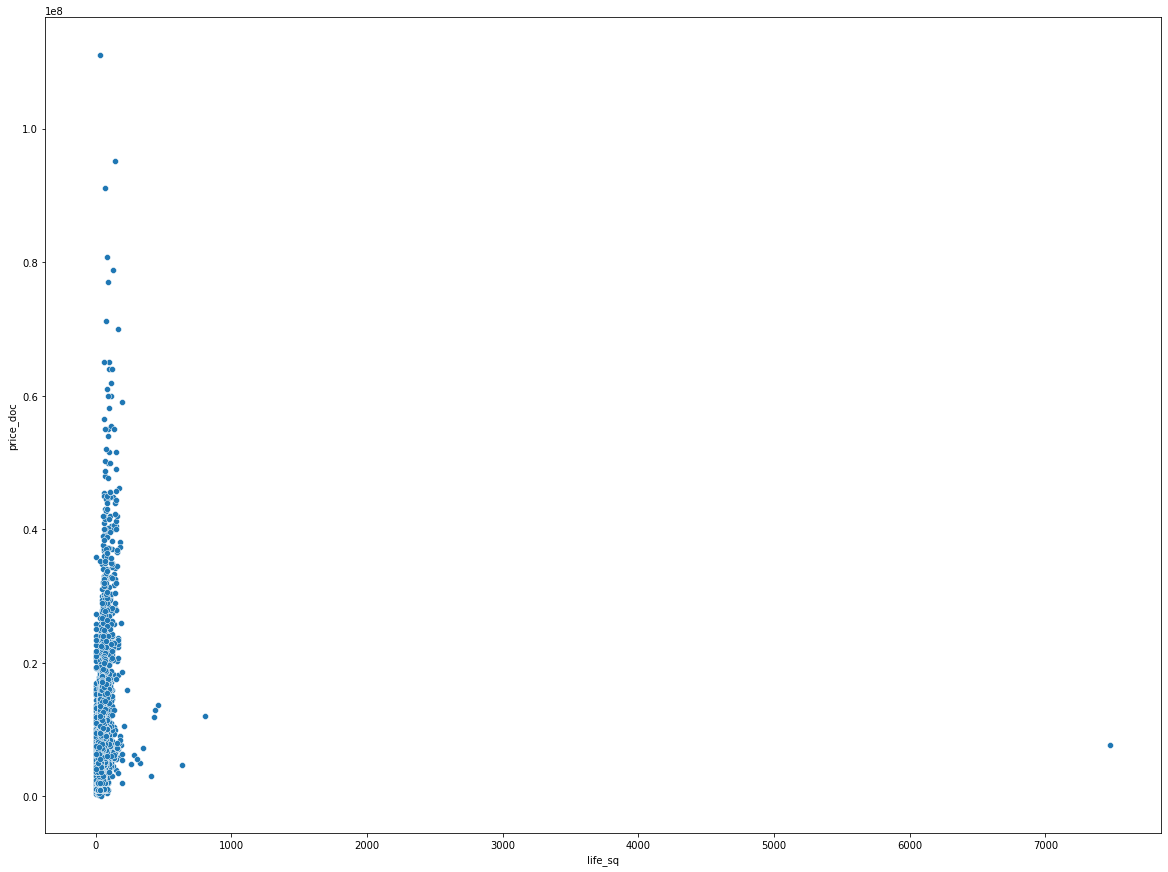

In [27]:
plt.figure(figsize=(20, 15))
sns.scatterplot(
    x = train['life_sq'],
    y = train['price_doc']
)

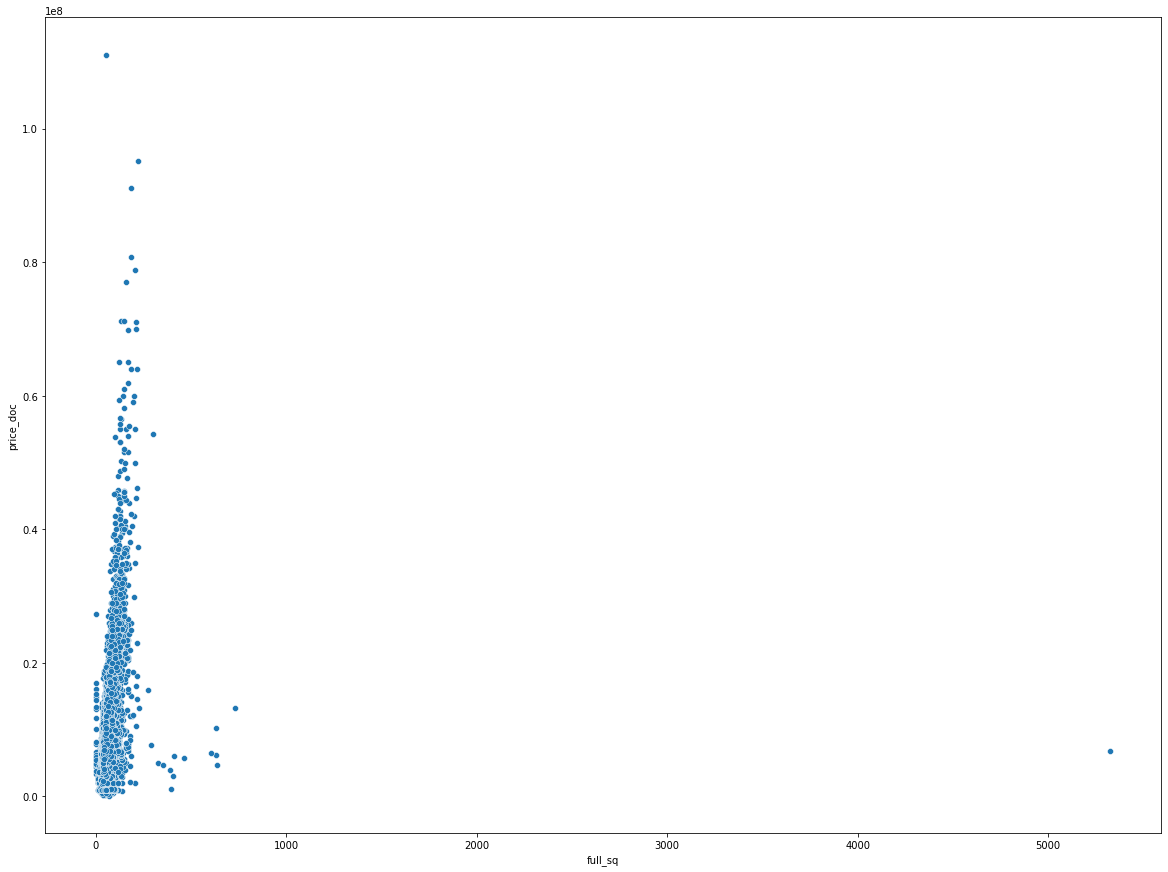

In [28]:
plt.figure(figsize=(20, 15))
sns.scatterplot(
    x = train['full_sq'],
    y = train['price_doc']
)

In [29]:
train['state'].unique()

array([nan,  3.,  1.,  2.,  4., 33.])

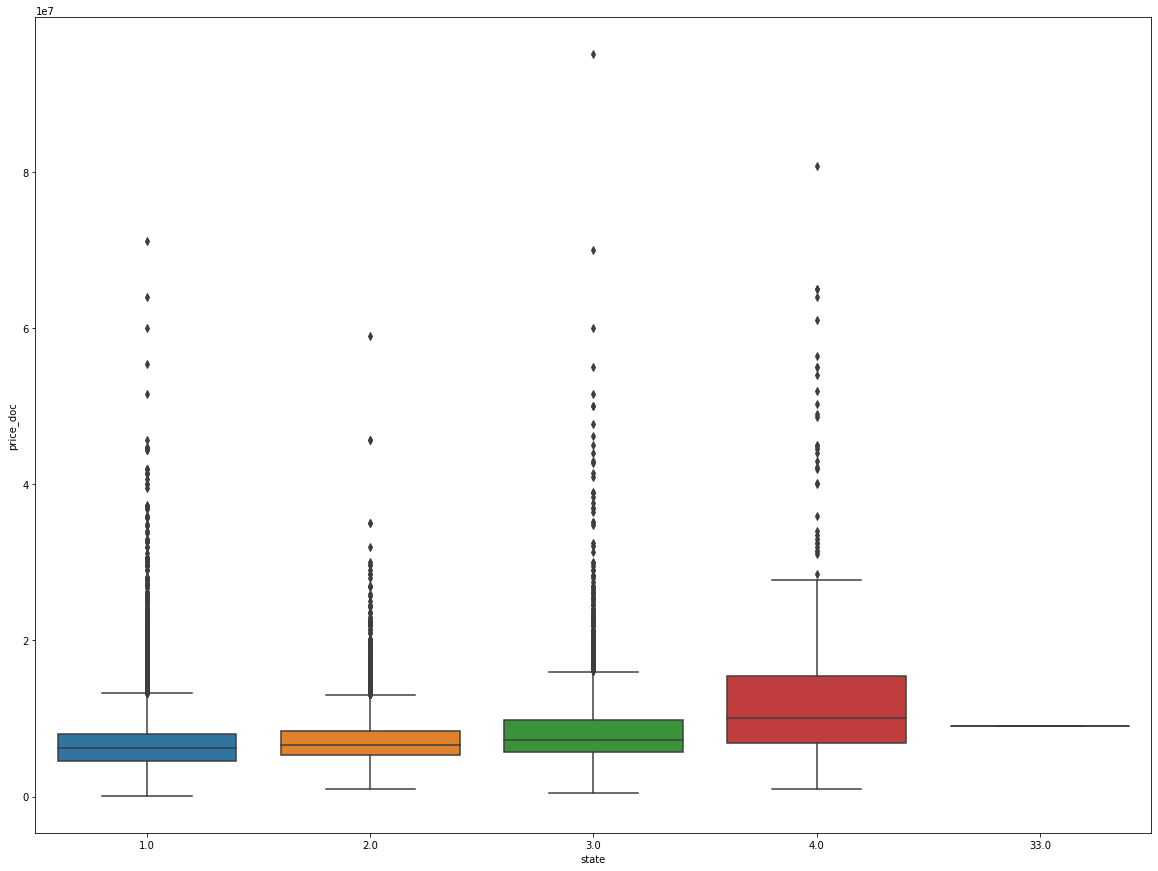

In [30]:
# using boxplot for state since it is a categorical column
plt.figure(figsize=(20, 15))
sns.boxplot(
    x = train['state'],
    y = train['price_doc']
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Price')

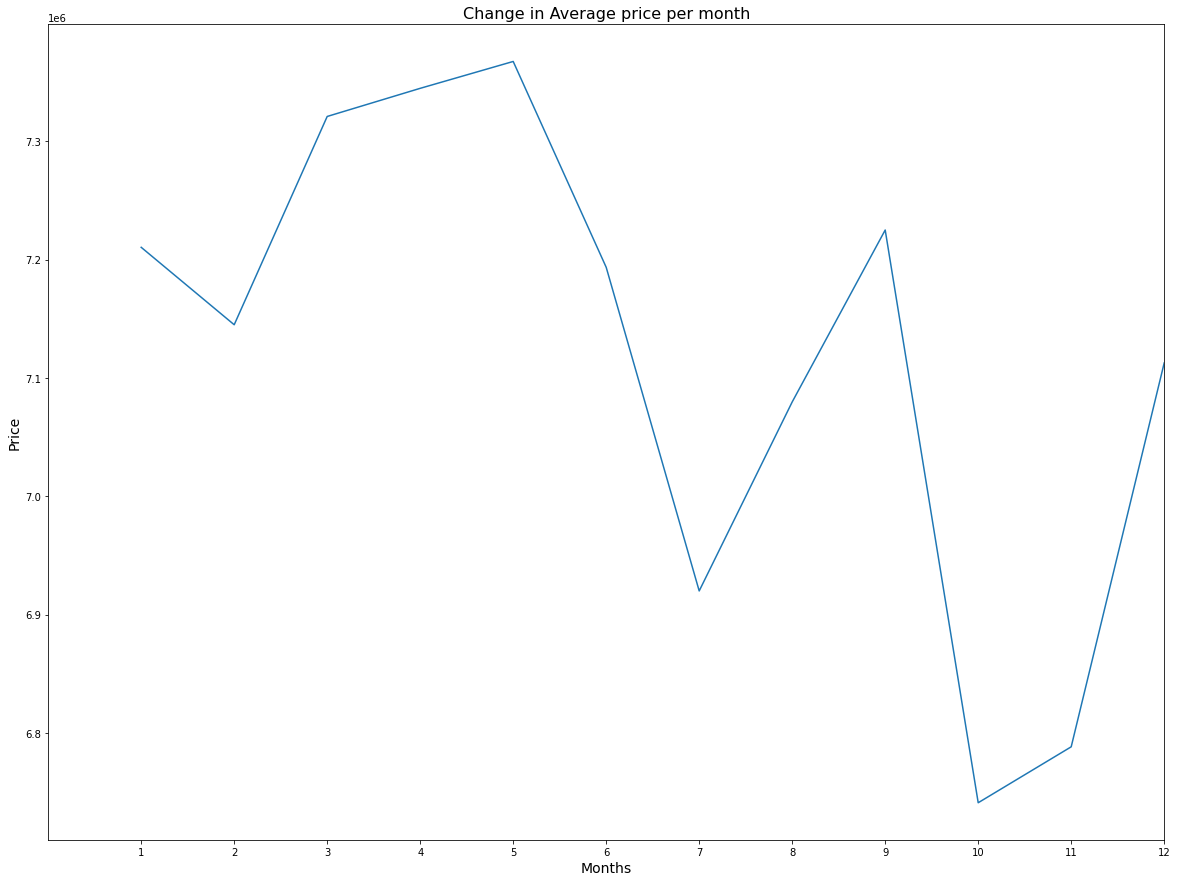

In [31]:
#Feature engineering
general_df['month'] = general_df['timestamp'].dt.month

# 12-09-2022
# 12092022
# 12/03/2022

plt.figure(figsize=(20, 15))

plt.plot(general_df.groupby('month')['price_doc'].mean())
plt.xlim(0, 12)
plt.xticks([i for i in range(1, 13)])

plt.title("Change in Average price per month", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Price", fontsize=14)


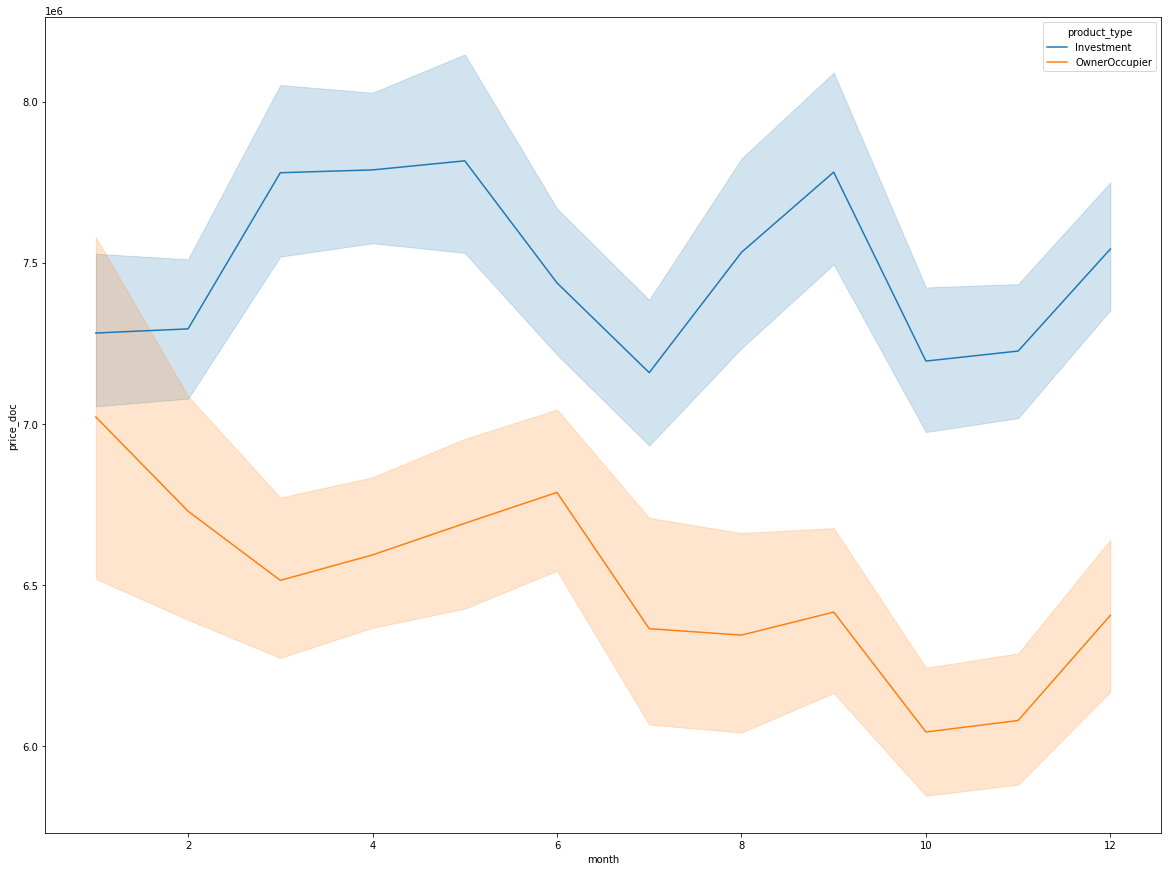

In [32]:
fig, ax = plt.subplots(figsize=(20, 15))

sns.lineplot(
    x="month",
    y='price_doc',
    data=general_df,
    hue='product_type'
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Price')

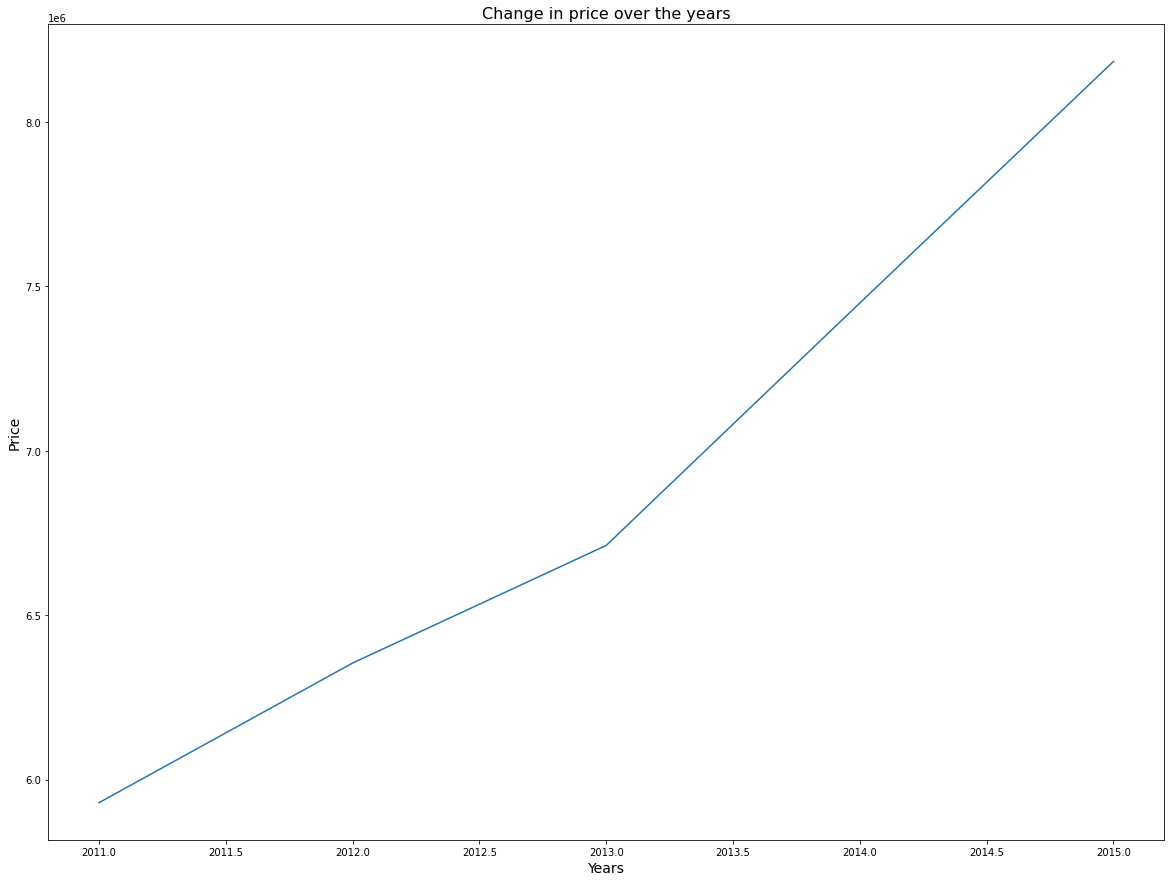

In [33]:
general_df['year'] = general_df['timestamp'].dt.year

fig, ax = plt.subplots(figsize=(20, 15))

plt.plot(general_df.groupby(['year'])['price_doc'].mean())
plt.title("Change in price over the years", fontsize=16)
plt.xlabel("Years", fontsize=14)
plt.ylabel("Price", fontsize=14)

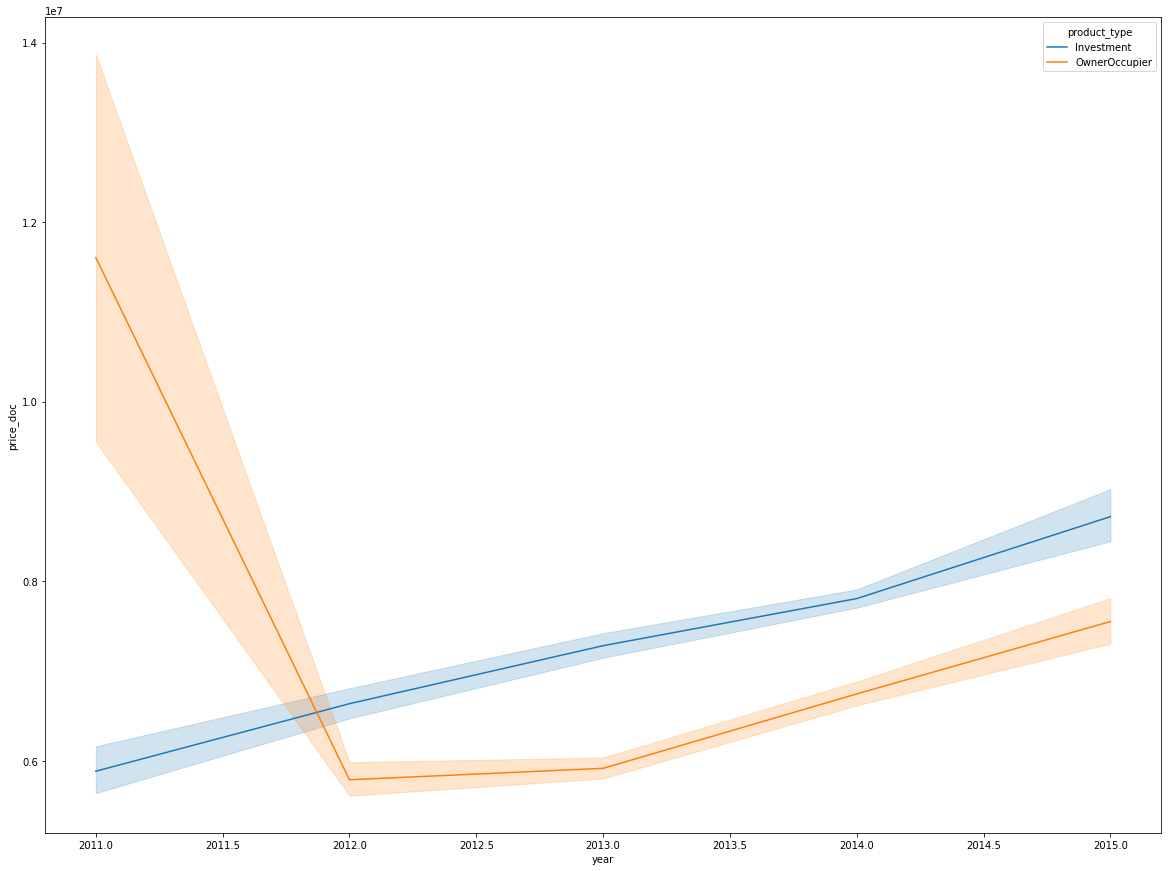

In [34]:
fig, ax = plt.subplots(figsize=(20, 15))

sns.lineplot(
    x="year",
    y='price_doc',
    data=general_df,
    hue='product_type'
)


In [35]:
sub_area = general_df.groupby(
    ['sub_area', 'product_type'])['price_doc'].mean().sort_values(ascending=False).reset_index()


In [36]:
sub_area

,sub_area,product_type,price_doc
0,Ajeroport,OwnerOccupier,7.124962e+07
1,Donskoe,OwnerOccupier,3.625691e+07
2,Zamoskvorech'e,OwnerOccupier,3.333046e+07
3,Hamovniki,OwnerOccupier,3.105268e+07
4,Presnenskoe,OwnerOccupier,2.686593e+07
...,...,...,...
238,Poselenie Shhapovskoe,Investment,2.925500e+06
239,Molzhaninovskoe,Investment,2.766667e+06
240,Poselenie Novofedorovskoe,OwnerOccupier,2.740497e+06
241,Poselenie Filimonkovskoe,Investment,2.685000e+06


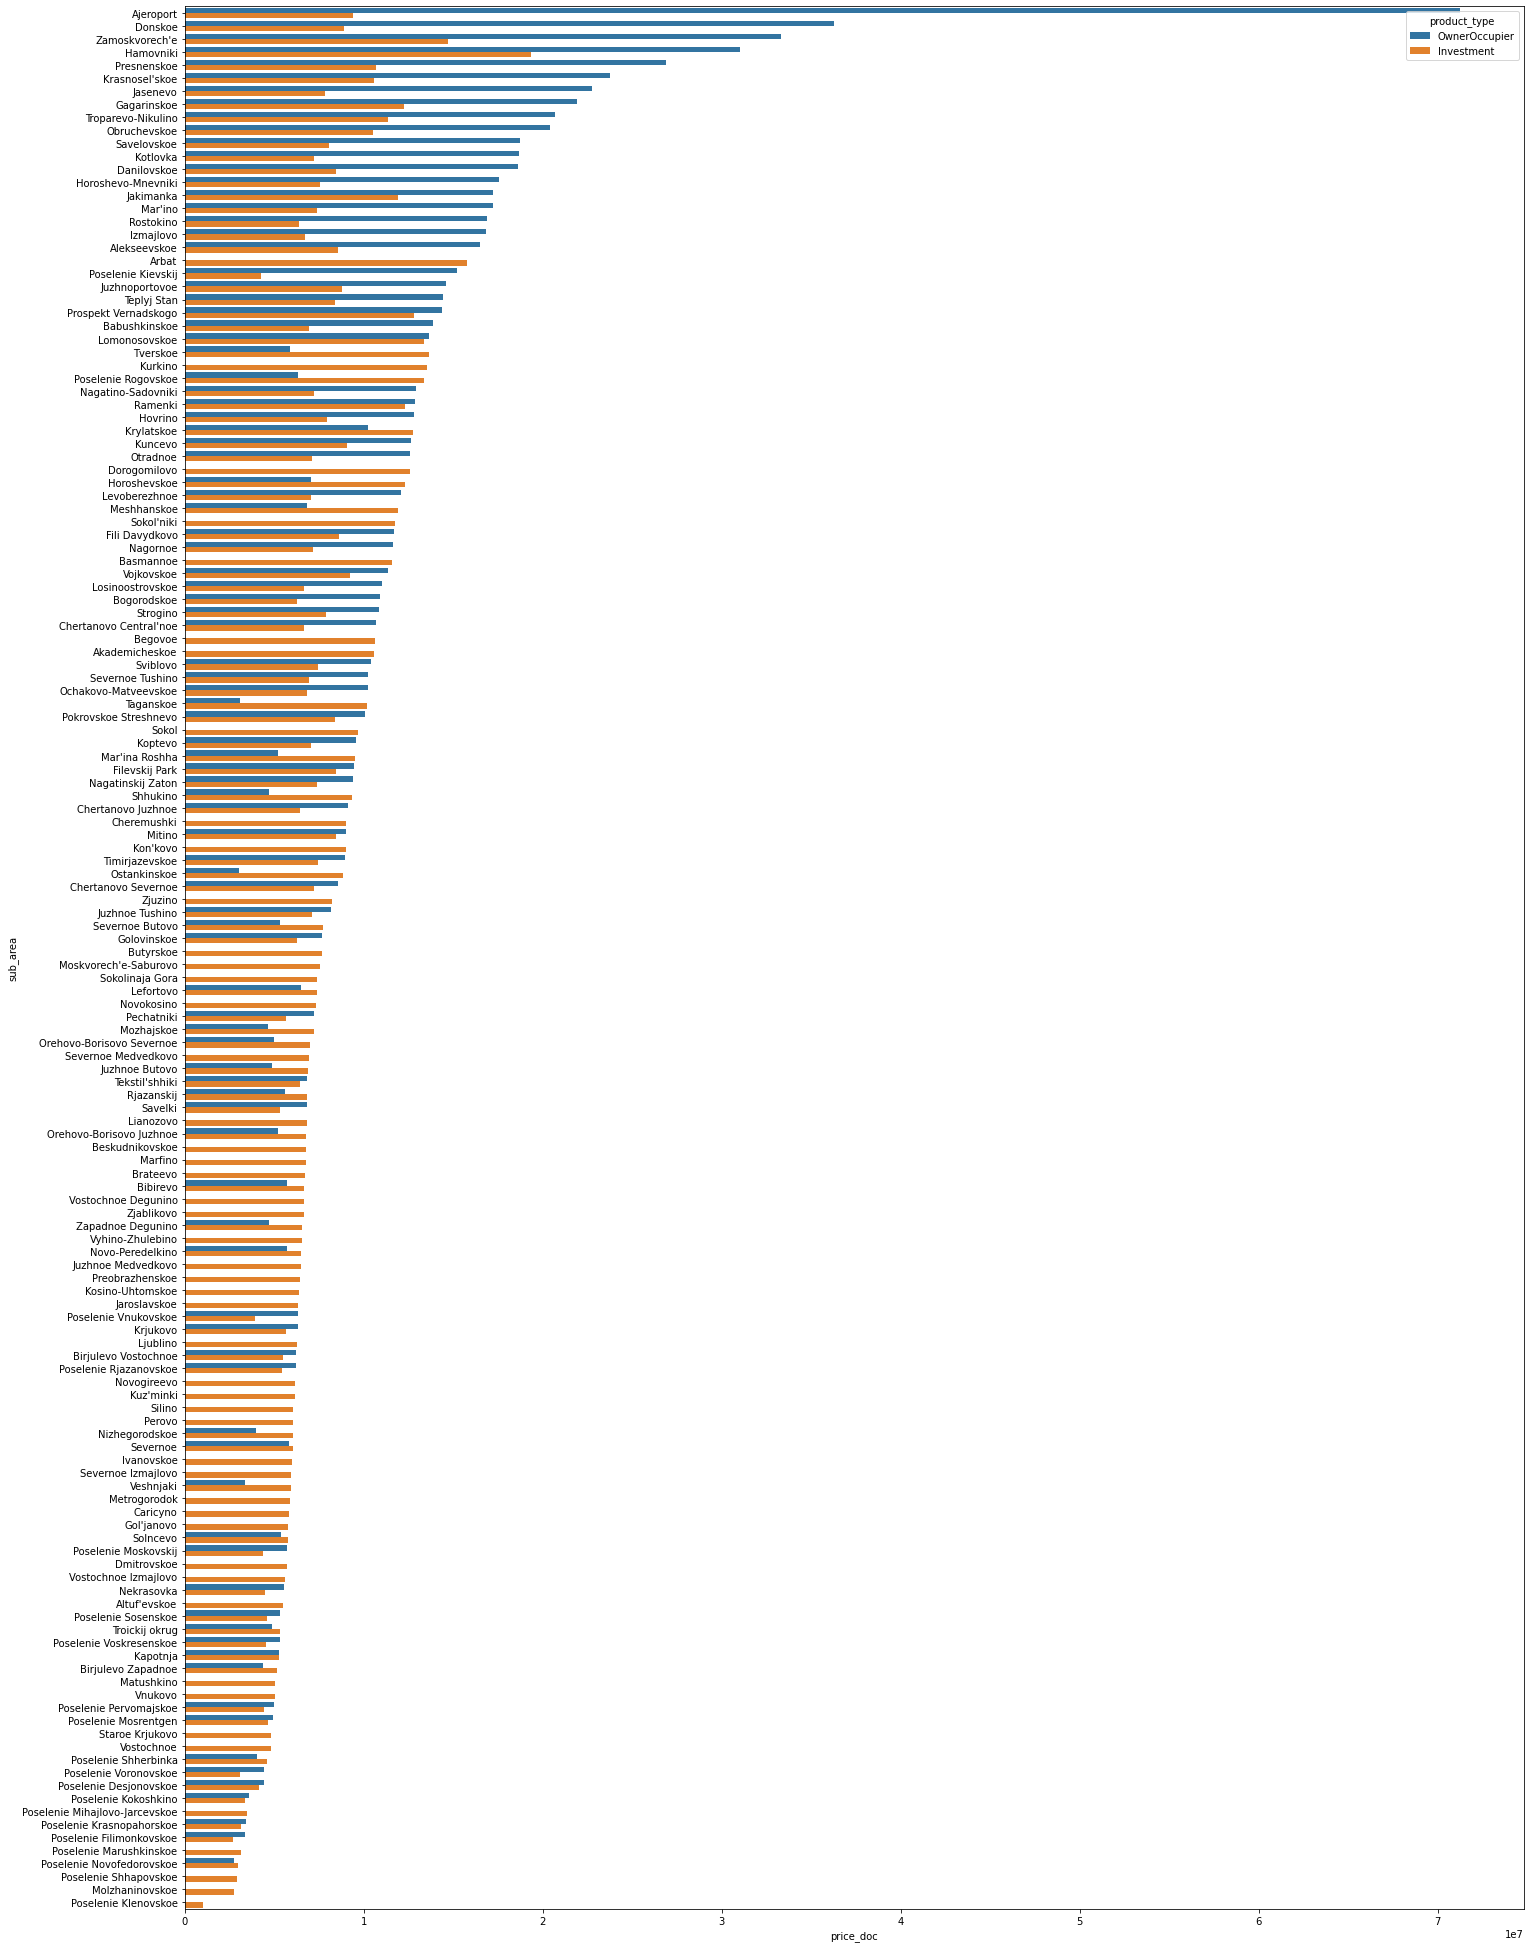

In [37]:
fig, ax = plt.subplots(figsize=(24, 35))

sns.barplot(
    x = 'price_doc',
    y = 'sub_area',
    hue="product_type",
    data = sub_area
)

In [38]:
corr = train.corr()
corr = corr['price_doc'].sort_values(ascending=False).reset_index()


In [39]:
zero_corr = corr[(corr['price_doc'] < 0.1) & (corr['price_doc'] > -0.1)]

zero_corr = zero_corr.set_index('index')

zero_corr = list(zero_corr.index)

In [40]:
# impute_missing(train)
train.isnull().sum().sort_values(ascending=False)

general_df.isnull().sum().sort_values(ascending=False)

build_year      13605
state           13559
max_floor        9572
material         9572
num_room         9572
kitch_sq         9572
life_sq          6383
floor             167
timestamp           0
full_sq             0
product_type        0
sub_area            0
price_doc           0
month               0
year                0
dtype: int64

In [41]:
train['state'].value_counts()
test['state'].value_counts()

train['state'].replace(to_replace=33, value=4, inplace=True)

In [42]:
train['build_year'].value_counts()

build_yr = {
    0: np.nan,
    1: np.nan,
    3: np.nan,
    20: np.nan,
    215: np.nan,
    20052009: 2005,
    4965: 1965,
    71: 1971
}
train['build_year'].replace(to_replace=build_yr, inplace=True)

test['build_year'].value_counts()
build_yr = {
    0: np.NaN,
    1: np.NaN,
    2: np.NaN,
    215: np.NaN,
}
test['build_year'].replace(to_replace=build_yr, inplace=True)


In [43]:
train['material'].value_counts()

train['material'].replace(to_replace=3, value=6, inplace=True)


In [44]:
train['material'].replace(to_replace=3, value=6, inplace=True)

test['material'].value_counts()
test['material'].replace(to_replace=3, value=6, inplace=True)


In [45]:
train['full_sq'].replace(to_replace=0, value=np.nan, inplace=True)
test['full_sq'].replace(to_replace=0, value=np.nan, inplace=True)

In [46]:
train['max_floor'].value_counts().sort_values(ascending=True)

max_floor_dict = {
    117: 17,
    0: np.NaN
}
train['max_floor'].replace(to_replace=max_floor_dict, inplace=True)


test['max_floor'].value_counts()
train['max_floor'].replace(to_replace=0, value=np.nan, inplace=True)


Missing Values Imputation

In [49]:
# num_columns = [x for x in train if train[x].dtype != "object" or if train[x]. ]
num_cols = []

for i in train:
    if ((train[i].dtype != "object") & (train[i].dtype != 'datetime64')):
        num_cols.append(i)

obj_cols = []
for i in train:
    if ((train[i].dtype == "object")):
        obj_cols.append(i)

obj_cols

date_cols = []

for i in train:
    if ((train[i].dtype == 'datetime64')):
        date_cols.append(i)

date_cols

'timestamp' in train[num_cols]

num_cols.remove('timestamp')

In [50]:
knnimpute = KNNImputer()

knnimpute.fit(train[num_cols])

KNNImputer()

In [51]:
pred = knnimpute.transform(train[num_cols])

In [52]:
pred_df = pd.DataFrame(pred, columns=num_cols)
pred_df.head()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,yearmonth
0,1.0,43.0,27.0,4.0,13.0,2.6,1975.6,1.0,7.2,2.2,...,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0,201108.0
1,2.0,34.0,19.0,3.0,17.0,4.8,2007.0,1.0,6.8,1.4,...,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0,201108.0
2,3.0,43.0,29.0,2.0,7.6,2.6,1963.2,1.4,6.2,2.4,...,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0,201108.0
3,4.0,89.0,50.0,9.0,18.0,2.6,2003.0,3.4,8.2,2.8,...,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0,201109.0
4,5.0,77.0,77.0,4.0,6.2,2.0,1949.8,3.4,7.4,2.6,...,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0,201109.0


In [53]:
train[num_cols] = pred_df

In [56]:
train.to_csv("/content/gdrive/MyDrive/Datasets/sberbank_housing/clean_train.csv")

In [57]:
train = pd.read_csv("/content/gdrive/MyDrive/Datasets/sberbank_housing/clean_train.csv", sep=",")

train = train.drop('Unnamed: 0', axis=1)

train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,yearmonth
0,1.0,2011-08-20,43.0,27.0,4.0,13.0,2.6,1975.6,1.0,7.2,...,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0,201108.0
1,2.0,2011-08-23,34.0,19.0,3.0,17.0,4.8,2007.0,1.0,6.8,...,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0,201108.0
2,3.0,2011-08-27,43.0,29.0,2.0,7.6,2.6,1963.2,1.4,6.2,...,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0,201108.0
3,4.0,2011-09-01,89.0,50.0,9.0,18.0,2.6,2003.0,3.4,8.2,...,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0,201109.0
4,5.0,2011-09-05,77.0,77.0,4.0,6.2,2.0,1949.8,3.4,7.4,...,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0,201109.0


In [58]:
for col in train.columns:
    if ('id' in col or "ID" in col):
        zero_corr.append(col)

zero_corr.append('timestamp')

In [59]:
for set_ in (train, test):
    set_.drop(zero_corr, axis=1, inplace=True)

In [60]:
num_cols = []
obj_cols = []

for col in train.columns:
    if (train[col].dtype != "object"):
        num_cols.append(col)
    else:
        obj_cols.append(col)

In [61]:
dummies = pd.get_dummies(train[obj_cols])
train = pd.concat([train, dummies], axis=1)

train = train.drop(train[obj_cols], axis=1)
train.head()


,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,43.0,27.0,4.0,1.0,2.2,6.407578e+06,155572.0,9576.0,5.0,10309.0,...,0,1,0,1,0,0,1,0,0,0
1,34.0,19.0,3.0,1.0,1.4,9.589337e+06,115352.0,6880.0,5.0,7759.0,...,0,1,0,1,0,1,0,0,0,0
2,43.0,29.0,2.0,1.4,2.4,4.808270e+06,101708.0,5879.0,4.0,6207.0,...,0,1,0,1,0,0,0,0,1,0
3,89.0,50.0,9.0,3.4,2.8,1.258354e+07,178473.0,13087.0,9.0,13670.0,...,0,1,0,1,0,0,1,0,0,0
4,77.0,77.0,4.0,3.4,2.6,8.398461e+06,108171.0,5706.0,7.0,6748.0,...,0,1,0,0,1,1,0,0,0,0


In [62]:
test_dummies = pd.get_dummies(test[obj_cols])

test = pd.concat([test, test_dummies], axis=1)
test = test.drop(test[obj_cols], axis=1)

In [63]:
X = train.drop("price_doc", axis=1)
y = train['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [65]:
linReg = LinearRegression()

linReg.fit(X_train_scaled, y_train)

LinearRegression()

In [67]:
X_test_scaled = scaler.transform(X_test)
pred = linReg.predict(X_test_scaled)

In [68]:
def RMSLE(y_true, y_pred):
    """A Function to calculate the root mean square error
     of the predictions made by the regressor"""

    msle = mean_squared_log_error(y_true, y_pred)

    rmsle = np.sqrt(msle)

    print(rmsle)

In [69]:
neg_vals = []

for i in range(len(pred)):
    if pred[i] < 0:
       pred[i]  = np.median(pred)


In [70]:
RMSLE(y_test, pred)

0.634781967663113


In [71]:
logReg = LogisticRegression()

params = {
    'max_iter': [x for x in range(99, 1001) if x % 10 == 0],
    'penalty': ['l2'],
    'max_iter': [100, 500, 1000],
    "C": [0.1, 0.5, 1, 10, 50, 100]
}


logReg_cv = HalvingGridSearchCV(
    logReg, param_grid=params, scoring="accuracy",
     cv=3, factor=3, min_resources=100, verbose=True)

In [72]:
logReg_cv.fit(X_train_scaled, y_train)



n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 5
min_resources_: 100
max_resources_: 24376
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 100
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

----------
iter: 1
n_candidates: 6
n_resources: 300
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

----------
iter: 2
n_candidates: 2
n_resources: 900
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


HalvingGridSearchCV(cv=3, estimator=LogisticRegression(), min_resources=100,
                    param_grid={'C': [0.1, 0.5, 1, 10, 50, 100],
                                'max_iter': [100, 500, 1000],
                                'penalty': ['l2']},
                    scoring='accuracy', verbose=True)

In [74]:
logReg_pred = logReg_cv.predict(X_test_scaled)

In [75]:
RMSLE(y_test, logReg_pred)

0.7344527796918952


In [91]:
params = {
   'max_depth': [x for x in range(1, 101) if x % 10 == 0],
   'max_leaf_nodes': [x for x in range(1,10) if x % 2 == 0] 
}

rnd_forest = HalvingGridSearchCV(
    RandomForestRegressor(), param_grid=params,
    scoring='neg_mean_squared_log_error', cv=3, random_state=42, verbose=True
  )

In [92]:
rnd_forest.fit(X_train_scaled, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 902
max_resources_: 24376
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 902
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 14
n_resources: 2706
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 2
n_candidates: 5
n_resources: 8118
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 24354
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=3, estimator=RandomForestRegressor(),
                    param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100],
                                'max_leaf_nodes': [2, 4, 6, 8]},
                    random_state=42, scoring='neg_mean_squared_log_error',
                    verbose=True)

In [95]:
rnd_forest.best_estimator_

RandomForestRegressor(max_depth=70, max_leaf_nodes=8)

In [97]:
y_pred = rnd_forest.predict(X_test_scaled)

In [98]:
RMSLE(y_test, y_pred)

0.5202265514945832
